Proof of scoring using x,y coordinate of dart tip

In [39]:
import cv2
import matplotlib.pyplot as plt
import os

cur_dir = os.getcwd()
parent_dir = os.path.dirname(cur_dir)
print(cur_dir)
print(parent_dir)

/Users/zach/Desktop/SDP/SmokingDartsv2/core
/Users/zach/Desktop/SDP/SmokingDartsv2


Load image of darts representing edge of scoring area, and an image of a dart representing center of scoring area.

Image of nodart


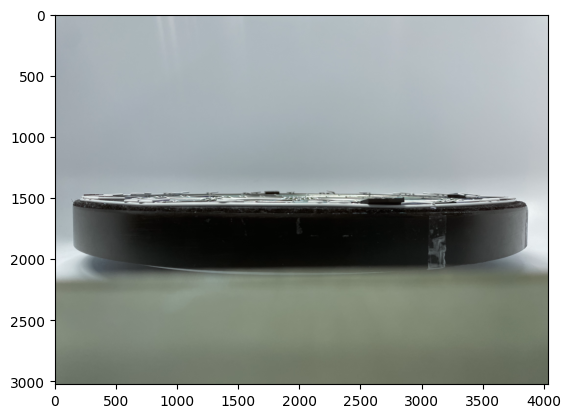

Image of dartx


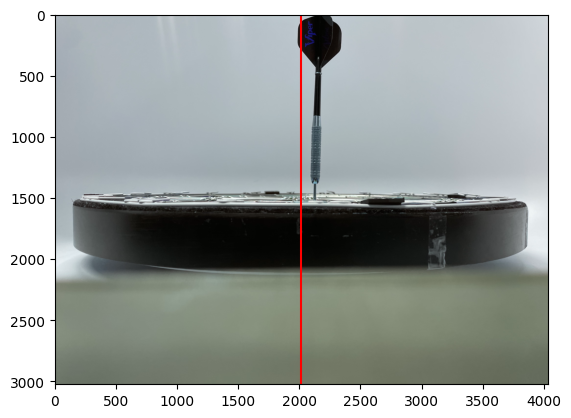

Image of darty


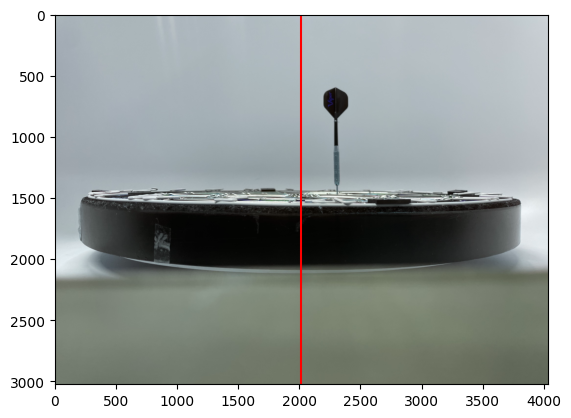

Image Resolution: 4032 x 3024


In [40]:
# load images
image_nodart = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'nodart_3.jpeg'))
image_dartX = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'dartx_3_1.jpeg'))
image_dartY = cv2.imread(os.path.join(parent_dir, 'images/3-2-23/', 'darty_3.jpeg'))

# display images
print("Image of nodart")
plt.imshow(image_nodart)
plt.show()

print("Image of dartx")
plt.plot([image_dartX.shape[1]//2, image_dartX.shape[1]//2], [0, image_dartX.shape[0]], 'r-')
plt.imshow(image_dartX)
plt.show()

print("Image of darty")
plt.plot([image_dartY.shape[1]//2, image_dartY.shape[1]//2], [0, image_dartY.shape[0]], 'r-')
plt.imshow(image_dartY)
plt.show()

image_height, image_width, channels = image_nodart.shape
print('Image Resolution: {} x {}'.format(image_width, image_height))



Create difference image to determine dart tip coordinates

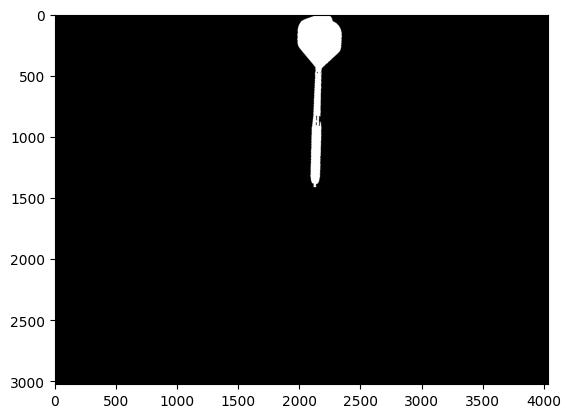

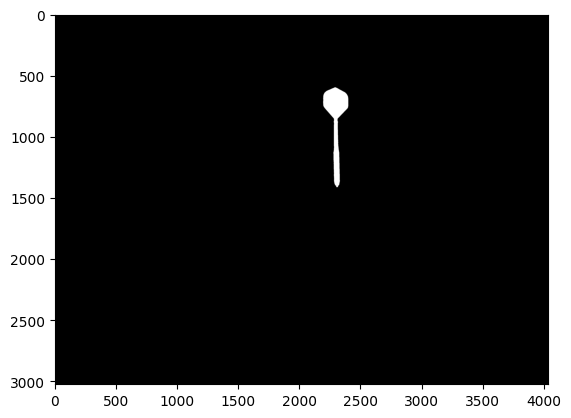

coordinates:  [2124.9156626506024, 2306.6921241050118]


In [41]:
from dart_tip_coordinate import *

def show_diff_image(dart, nodart):
    # dartboard
    db = DartboardImage("x", dart, last_img=nodart)
    diff = db.get_diff_to_last_img()

    # set left most 100 pixels to 0
    diff[:, :100] = 0

    # set 1400 to image_height to 0
    diff[1415:, :] = 0

    # opencv dilation
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.dilate(diff.astype('uint8'),kernel,iterations = 1)

    # opencv erosion 
    kernel = np.ones((5,5),np.uint8)
    diff = cv2.erode(diff.astype('uint8'),kernel,iterations = 1)

    # get the tip
    isolated_dart_tip = isolate_dart_tip(diff)
    y_coordinate, x_coordinate = center_of_mass(isolated_dart_tip)

    # show image diff
    plt.imshow(diff, cmap='gray')
    plt.show()
    return x_coordinate


x = show_diff_image(image_dartX, image_nodart)
y = show_diff_image(image_dartY, image_nodart)
darttip_pixel_coordinates = [x, y]
print("coordinates: ", darttip_pixel_coordinates)

Determine pixel width of board

In [42]:
#trash
board_width = image_width

Determine Angle of Camera to Dart

In [43]:
# compute the angles from the camera to the dart using pixel width of board and camera field of view
def angle_from_camera_to_dart(coordinates, board_width = 2592, fov=62.2):
    angle = [0, 0]
    angle[0] = coordinates[0] / board_width * fov
    angle[1] = coordinates[1] / board_width * fov
    return angle

# get image dimensions
fov = 67
angles_cameras_to_darts = angle_from_camera_to_dart(darttip_pixel_coordinates, board_width, fov)
print("coordinates:", darttip_pixel_coordinates)
print("dart_angles:", angles_cameras_to_darts)

coordinates: [2124.9156626506024, 2306.6921241050118]
dart_angles: [35.30985848154523, 38.33044948289578]


In [44]:
import matplotlib.pyplot as plt
import math


cam_dist = 440 ## mm
board_radius = 228.6 #mm

angA = float(input("Enter Angle for CamA in degrees: "))
angB = float(input("Enter Angle for CamB in degrees: "))
FOV = float(input("Enter Field of View in degrees: "))


mod_angA, mod_angB = (FOV/2 - angA) , (FOV/2 - angB) + 90

angA, angB  = mod_angA * math.pi/180, mod_angB * math.pi/180

slopeA = math.tan(angA)
slopeB = math.tan(angB)

x_dart = (15*slopeA - 15)/(slopeA - slopeB)
y_dart = (x_dart + 15) * slopeA
print(x_dart)
print(y_dart)

fig, ax = plt.subplots() 

ax.set_xlim(-cam_dist, cam_dist)
ax.set_ylim(-cam_dist, cam_dist)



dart_board = plt.Circle((0, 0), board_radius, edgecolor='black', fill=False)
dart = plt.Arrow(x_dart, y_dart, 3, 3, color='black')
bullseye = plt.Circle((0, 0), 10, edgecolor='black', fill=False)

camA = plt.Rectangle((-cam_dist, -5), 1, 1, edgecolor='black', fill=False, clip_on=False)
camB = plt.Rectangle((-5, -cam_dist), 1, 1, edgecolor='black', fill=False, clip_on=False) 



leg_Cam1_Dart = ax.axline((-cam_dist, 0), slope = math.tan(angA))
leg_Cam2_Dart = ax.axline((0, -cam_dist), slope = math.tan(angB))

ax.plot(x_dart, y_dart)

ax.add_patch(dart_board)
ax.add_patch(dart)
ax.add_patch(bullseye)
ax.add_patch(camA)
ax.add_patch(camB)
plt.show()


ValueError: could not convert string to float: ''

Calculate x, y coordinates of dart tip relative to bullseye (0,0)

In [ ]:
# Calculate distance between cameras using pythagorean theorem
distance_camera_to_center_cm = 42.5
distances_camera_to_camera_cm = math.sqrt(2)*distance_camera_to_center_cm
print("distance_camera_to_camera_cm:", distances_camera_to_camera_cm)

# Calculate angles of triangle made from the sides of dart to the cameras, and camera to camera side
# This is done using obtained angles: AngA from CamX and AngB from camY:
# A = (31.1 - ang1) + 45, B=(ang2 - 31.1) + 45, C = 90 - (A+B) where A is angle close to CamX, B is close to CamY and C close to dart
angleA = 27 - angles_cameras_to_darts[0] + 45
angleB = angles_cameras_to_darts[1] - 27 + 45
angleC = 90-(angleA + angleB)
print("angle_A:", angleA)
print("angle_B:", angleB)
print("angle_C:", angleC)

# Use law of sines to compute one of the legs: distance_cameraY_Dart = distances_camera_to_camera_cm*sin(angleA)/sin(angleC)
distance_cameraY_to_dart = distances_camera_to_camera_cm * math.sin(angleA) / math.sin(angleC)
print("distance_cameraX_Dart:", distance_cameraY_to_dart)

# Use leg length and angle to convert to x,y location relative to bullseye location of (0,0) 

# Use scoring algorithm on x,y location


distance_camera_to_camera_cm: 60.10407640085654
angle_A: 43.955316060473265
angle_B: 46.044683939526735
angle_C: 0.0


ZeroDivisionError: float division by zero

In [ ]:
center_of_board = 1247.15
print("center of board:", center_of_board)
board_length_pixels = 2175
board_length_cm = 34.29
pixels_per_cm = board_length_pixels/board_length_cm
print("pixels_per_cm: ", pixels_per_cm)

center_to_x_pixel = abs(darttip_pixel_coordinates[0] - center_of_board)
center_to_y_pixel = abs(darttip_pixel_coordinates[1] - center_of_board)
center_to_x_cm = center_to_x_pixel/pixels_per_cm
center_to_y_cm = center_to_y_pixel/pixels_per_cm
print(center_to_x_cm, center_to_y_cm)



center of board: 1247.15
pixels_per_cm:  63.42957130358705
14.222502577883471 14.222502577883471


In [ ]:
from scoreboard import get_score

# get score
score = get_score(center_to_x_cm, center_to_y_cm)
print("score: ", score)

Missed. Try Again.
score:  0
